In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
import mistsim as ms

In [2]:
NBINS = 24

### Load data

['ant_temp', 'freq', 'lst']


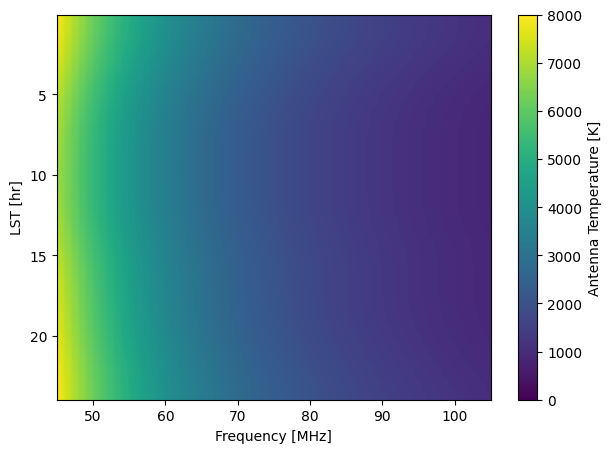

In [3]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

### Global signal

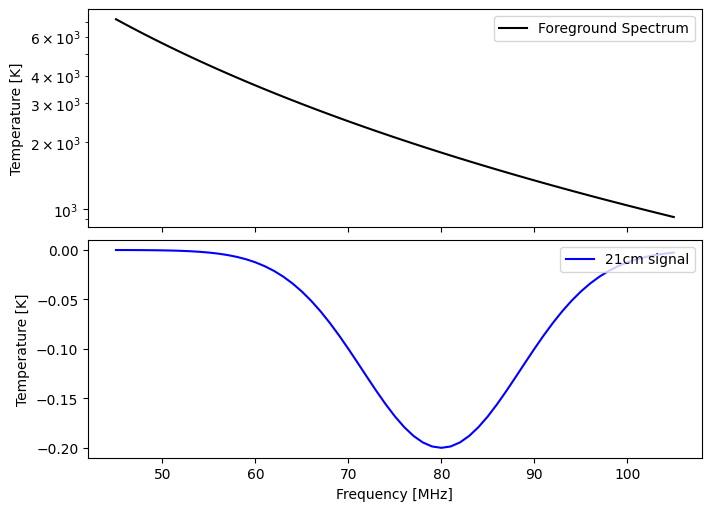

In [4]:
TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = ms.utils.gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

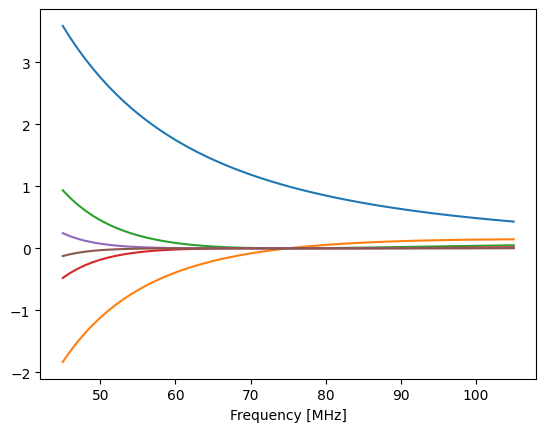

In [5]:
A = ms.utils.design_mat(freq, 6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the standard deviation is proportional to the system temperature and inversly proportional to the root of the integration time.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [6]:
cut = nspec % NBINS
total_temp = temp + TRUE_T21

if cut == 0:
    binned = total_temp.copy()
else:
    binned = total_temp[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)


tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = total_temp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

In [7]:
NFG = [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 5, 5, 4, 4, 4, 7, 4, 5, 5, 5, 4]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i]) for i in range(NBINS)]

### Run sampler

In [9]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
results = ms.run_sampler(bounds, lst_bins)


Iter: 0it [00:00, ?it/s]
Iter: 0it [00:00, ?it/s, calls=250, beta=0, logZ=0]
Iter: 1it [00:00, 44.78it/s, calls=500, beta=0, logZ=0]
Iter: 2it [00:00, 62.26it/s, calls=750, beta=0, logZ=0]
Iter: 3it [00:00, 71.16it/s, calls=1000, beta=0, logZ=0]
Iter: 4it [00:00, 77.33it/s, calls=1250, beta=0, logZ=0]
Iter: 5it [00:00, 80.90it/s, calls=1500, beta=0, logZ=0]
Iter: 6it [00:00, 82.95it/s, calls=1750, beta=0, logZ=0]
Iter: 7it [00:00, 85.69it/s, calls=2000, beta=0, logZ=0]
Iter: 9it [00:00, 88.57it/s, calls=2000, beta=0.00118, logZ=[[-5.36988107 -5.36988107 -5.36988107 -5.36988107 -5.36988107 -5.36988107
  -5.36988107 -5.36988107]
 [-5.36988107 -5.36988107 -5.36988107 -5.36988107 -5.36988107 -5.36988107
  -5.36988107 -5.36988107]
 [-5.36988107 -5.36988107 -5.36988107 -5.36988107 -5.36988107 -5.36988107
  -5.36988107 -5.36988107]
 [-5.36988107 -5.36988107 -5.36988107 -5.36988107 -5.36988107 -5.36988107
  -5.36988107 -5.36988107]
 [-5.36988107 -5.36988107 -5.36988107 -5.36988107 -5.36988107

IndexError: index 2016 is out of bounds for axis 0 with size 2000

In [10]:
%debug

> /home/christian/Documents/research/MIST/mistsim/.venv/lib/python3.10/site-packages/pocomc/sampler.py(575)_reweight()
    573 
    574         idx, weights = trim_weights(np.arange(len(weights)), weights, ess=0.99, bins=1000)
--> 575         current_particles["u"] = self.particles.get("u", index=None, flat=True)[idx]
    576         current_particles["x"] = self.particles.get("x", index=None, flat=True)[idx]
    577         current_particles["logdetj"] = self.particles.get("logdetj", index=None, flat=True)[idx]



ipdb>  u


> /home/christian/Documents/research/MIST/mistsim/.venv/lib/python3.10/site-packages/pocomc/sampler.py(314)run()
    312 
    313             # Choose next beta based on ESS of weights
--> 314             self.current_particles = self._reweight(self.current_particles)
    315 
    316             # Train Preconditioner



ipdb>  ll


    226     def run(self,
    227             n_total: int = 5000,
    228             n_evidence: int = 5000,
    229             progress: bool = True,
    230             resume_state_path: Union[str, Path] = None,
    231             save_every: int = None):
    232         r"""Run Preconditioned Monte Carlo.
    233 
    234         Parameters
    235         ----------
    236         n_total : int
    237             The total number of effectively independent samples to be
    238             collected (default is ``n_total=5000``).
    239         n_evidence : int
    240             The number of importance samples used to estimate the
    241             evidence (default is ``n_evidence=5000``). If ``n_evidence=0``,
    242             the evidence is not estimated using importance sampling and the
    243             SMC estimate is used instead. If ``preconditioned=False``,
    244             the evidence is estimated using SMC and ``n_evidence`` is ignored.
    245     

ipdb>  self.n_prior


2000


ipdb>  self.n_active


250


ipdb>  self.scaler


ipdb>  print(x.shape)


(250, 3)


ipdb>  print(u.shape)


(250, 3)


ipdb>  exit


In [9]:
ms.Sampler?

Init signature: ms.Sampler(n_dim, bounds)
Docstring:      <no docstring>
File:           ~/Documents/research/MIST/mistsim/.venv/lib/python3.10/site-packages/mistsim/sampler.py
Type:           type
Subclasses:     

In [13]:
from scipy.stats import uniform

In [14]:
uniform(loc=[1, 2, 3], scale=[1, 2, 3])

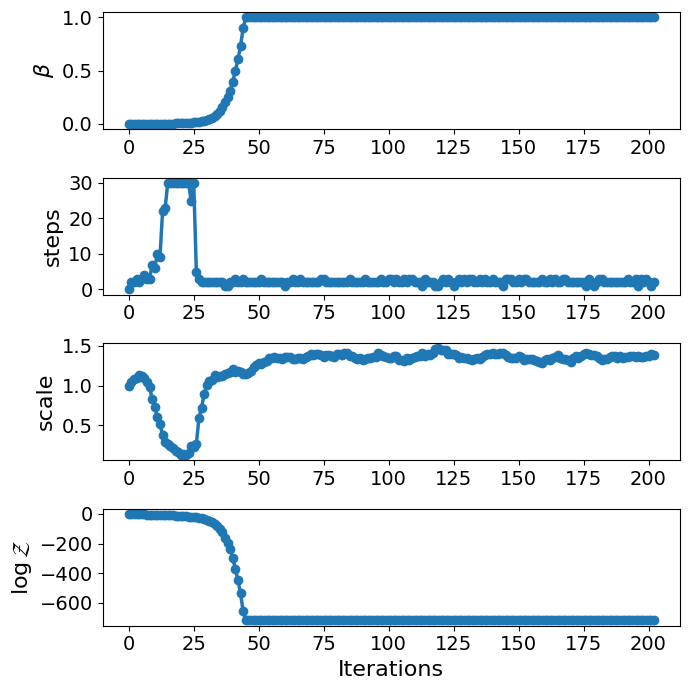

In [10]:
_ = pc.plotting.run(results, width=7, height=7)

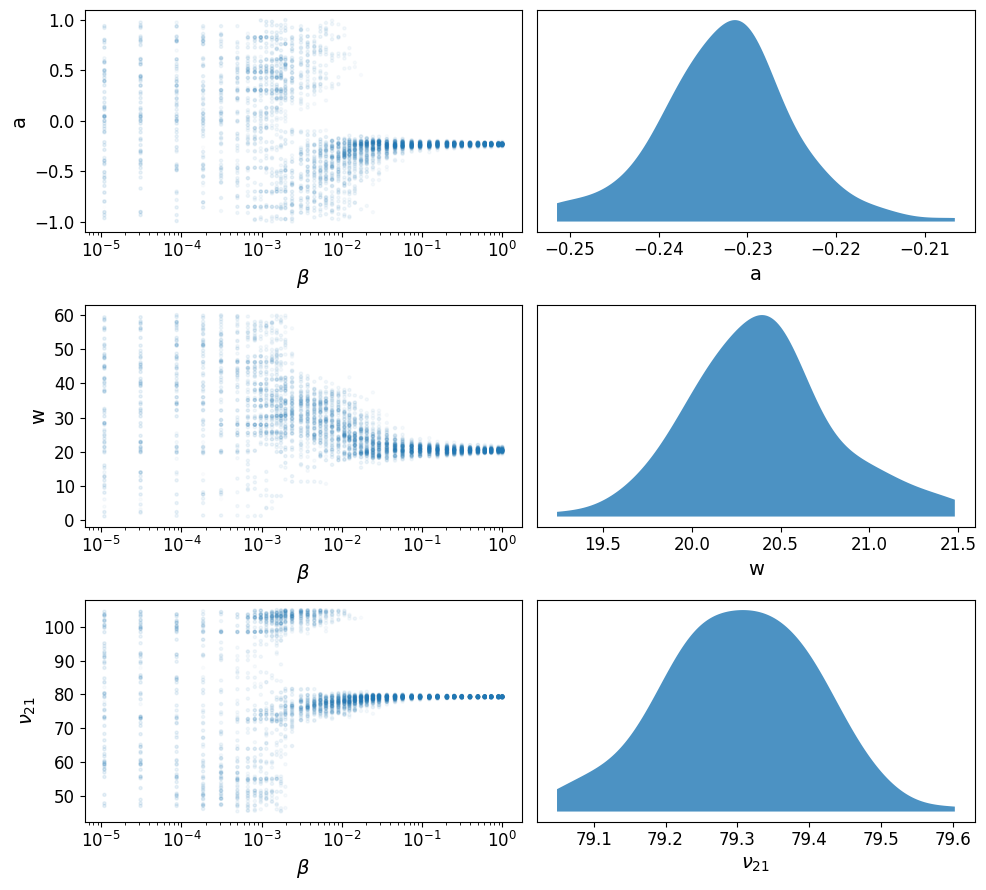

In [11]:
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)

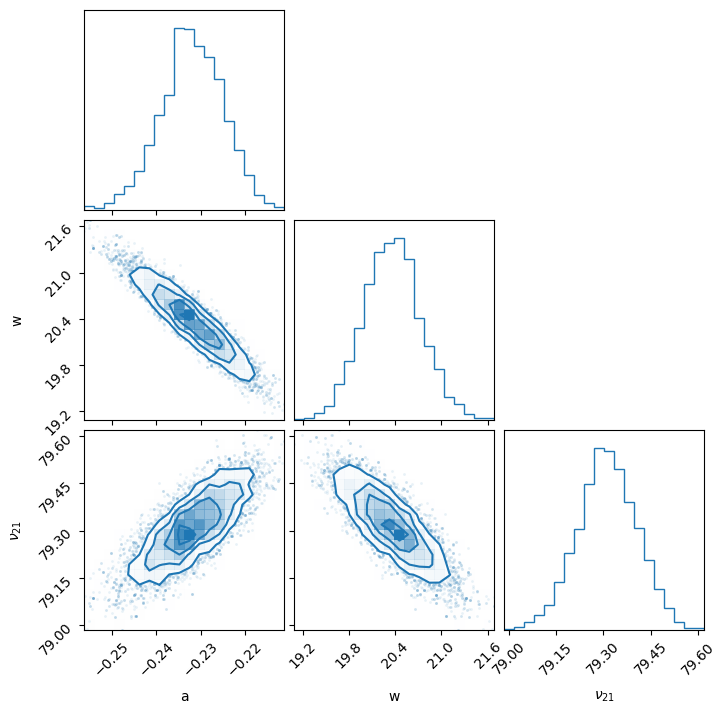

In [14]:
_ = pc.plotting.corner(results, labels=labels)#, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [13]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.23188569 20.363483   79.31295   ]
Standard deviation values =  [0.00697079 0.36832172 0.09356264]

[13.75060574  1.78497667  0.86625181]
[4.57418719 0.98686396 7.34320733]


# Chromaticity correction

['ant_temp', 'freq', 'lst']


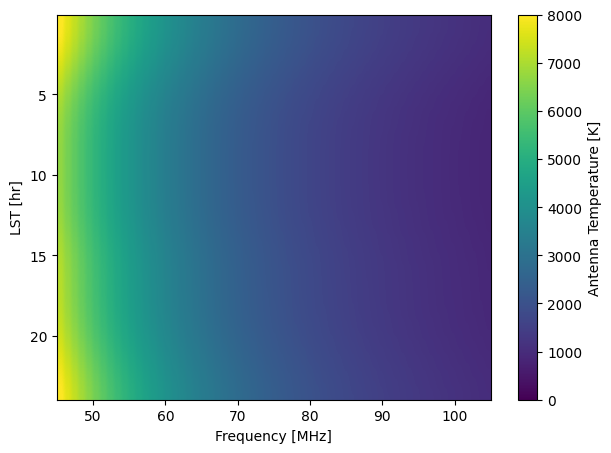

In [15]:
ac_temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5",
    print_key=True,
)[-1]

ac_temp = ac_temp[:, indx]


plt.figure(figsize=(7,5))
im = plt.imshow(
    ac_temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

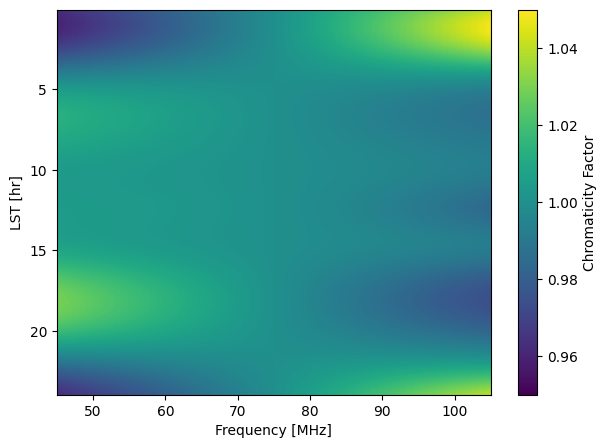

In [16]:
chrom = temp / ac_temp  # chromaticity factor (BF)

plt.figure(figsize=(7,5))
im = plt.imshow(
    chrom, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0.95, 1.05)
plt.colorbar(label="Chromaticity Factor")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

In [17]:
ctemp = (temp+TRUE_T21) / chrom  # = ac temp, the waterfall due to achromatic beam

print(np.allclose(ctemp, ac_temp))
if cut == 0:
    binned = ctemp.copy()
else:
    binned = ctemp[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
chrom_mean = chrom.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
print(chrom_mean.shape)

tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = ctemp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

False
(1, 61)


In [18]:
NFG = [5]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i]) for i in range(NBINS)]

In [19]:
nparticles = 64
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 
results = sampler.run_sampler(lst_bins, add_samples=10000)

Iter: 46it [02:38,  3.44s/it, beta=1, calls=35520, ESS=0.997, logZ=-34.4, accept=0.258, N=2, scale=1.15, corr=0.688]        
Iter: 157it [00:12, 12.57it/s, beta=1, calls=57408, ESS=0.95, logZ=-34.4, accept=0.244, N=3, scale=1.09, corr=0.561]


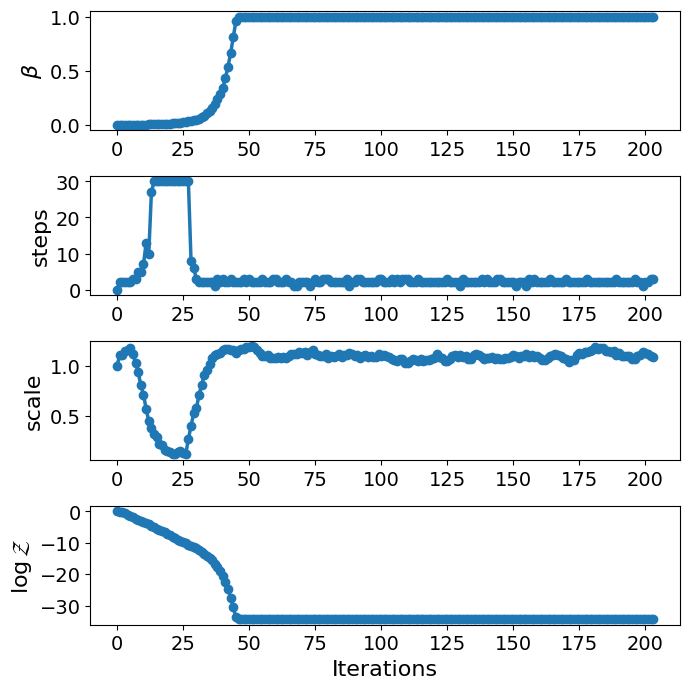

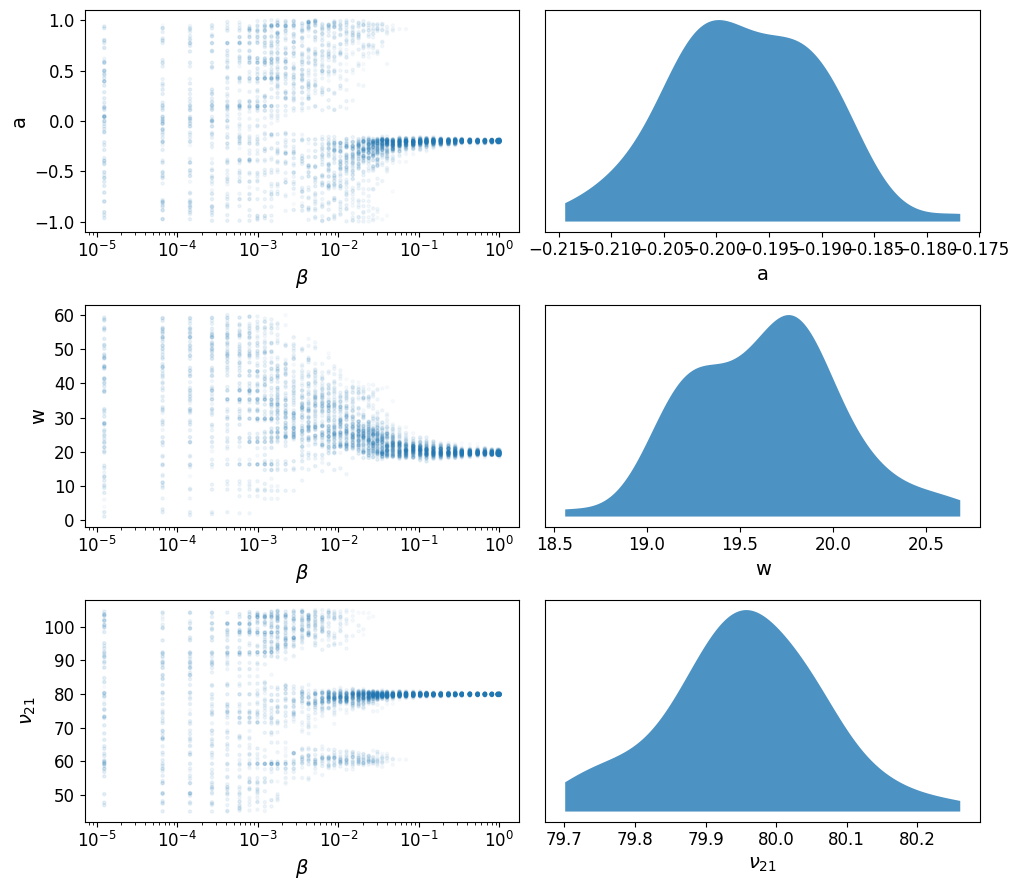

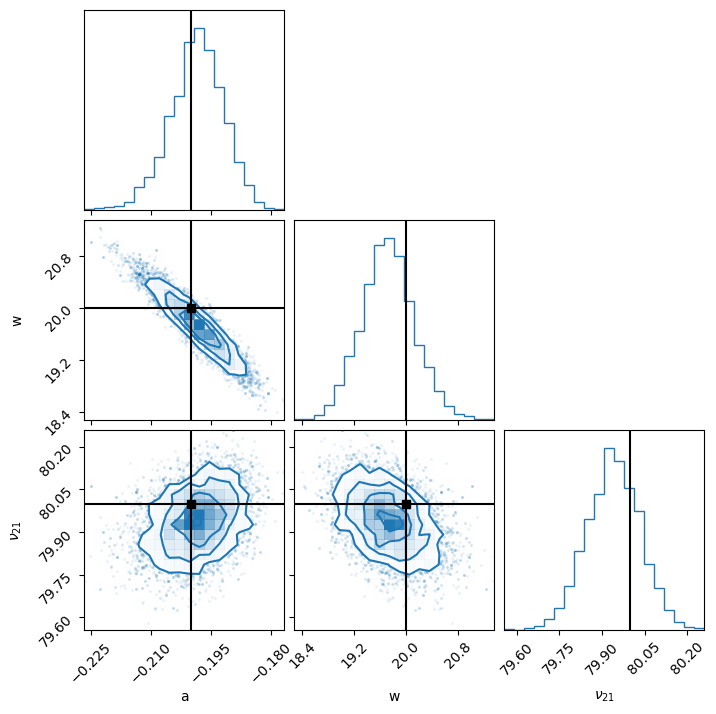

In [20]:
_ = pc.plotting.run(results, width=7, height=7)
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [21]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.19845247 19.722803   79.94126   ]
Standard deviation values =  [0.00666639 0.4067799  0.09327533]

[0.77979745 1.40546393 0.07347734]
[0.23213856 0.68144196 0.62973466]
